In [1]:
import pandas as pd
import numpy as np
import math

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# for training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# for optimize
from skopt import gp_minimize, Optimizer
from skopt.space import Space, Integer, Real

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
import pandas as pd
import numpy as np
from bayes_opt import expected_improvement, propose_location

import matplotlib.pyplot as plt


In [2]:
# meta config
random_seed = 2022

In [3]:
data = pd.read_csv("./data/boston_housing.csv")
data.head(5)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [4]:
X = data.drop(columns=['medv'])
y = data['medv'].values

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size=0.33, random_state=random_seed)

In [6]:
def train_and_evaluate(params):
    n_components, alpha = params[0], params[1]
    # PCA Analysis
    pca = PCA(n_components=round(n_components))
    pca.fit(X_train)
    X_train_tranformed = pca.transform(X_train)
    clf = Ridge(alpha=alpha).fit(X_train_tranformed, y_train)
    X_test_transformed = pca.transform(X_test)
    y_pred = clf.predict(X_test_transformed)
    return mean_squared_error(y_test, y_pred)

In [7]:
space = Space((Integer(1, 12), Real(0.001, 10, prior="log-uniform", base=10)))

In [8]:
res = gp_minimize(train_and_evaluate,        # the function to minimize
                    space,      # the bounds on each dimension of x
                    initial_point_generator="grid",
                    x0=[(2, 1.0)],
                    acq_func="EI",      # the acquisition function
                    n_calls=10,         # the number of evaluations of f
                    n_random_starts=5,  # the number of random initialization points
                    noise="gaussian",       # the noise level (optional)
                    n_jobs=-1,
                    random_state=random_seed)   # the random seed

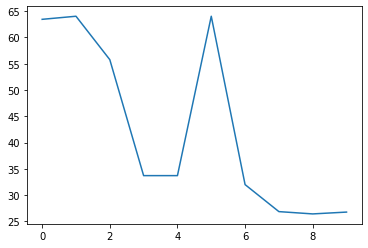

In [9]:
plt.plot(res.func_vals)

In [10]:
# collaborative optimization

class AgentBase:
    def __init__(self, other_params, model):
        self.punish = 0
        self.model = model
        self.params = [self.initialize_self_params(), other_params]
    
    def initialize_self_params(self):
        raise NotImplemented("param initialization not implemented")
    
    def update(self, budget):
        

IndentationError: expected an indented block (<ipython-input-10-263521bef96e>, line 13)

In [15]:
kernel = res.models[0].kernel_
gpr = GaussianProcessRegressor(kernel=kernel)

In [16]:
X_init = np.asarray([[2, 1.0], [4, 0.1]])
Y_init = np.array([[train_and_evaluate(x)] for x in X_init])

X_sample = X_init
Y_sample = Y_init

with warnings.catch_warnings():
    for i in range(20):
        gpr.fit(X_sample, Y_sample)
        X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, space, n_restarts=5)
        print(X_next[0])
        Y_next = train_and_evaluate(X_next)
        # Add sample to previous samples
        X_sample = np.vstack((X_sample, X_next))
        Y_sample = np.vstack((Y_sample, Y_next))

1
1
1


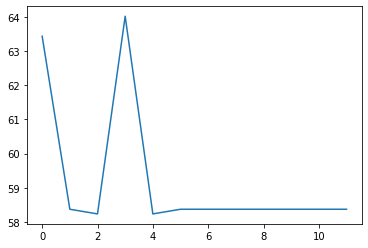

In [ ]:
plt.plot(Y_sample)